# semantic segmentation

# 1. library import

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 2. DeepLabModel

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 3. image shallow focus

In [5]:
img_dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'

+ 흐린배경과 크로마키 함수화

In [6]:
def shallow_focus(filename,label,chromafile):
    img_path = os.path.join(img_dir_path,filename)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 DeepLabModel에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    # 해당 Label영역 검출
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 결과를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    # 배경 blur처리하기
    img_orig_blur = cv2.blur(img_orig, (13,13))
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    if chromafile == 'blur':
        # 흐린배경과 원본 이미지 합치기
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
        fig = plt.figure(figsize = (10,10))
        fig.add_subplot(1,2,1).set_title('Original Image')
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        
        fig.add_subplot(1,2,2).set_title('Blur Image')
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
        
    else:
        chroma_path = os.path.join(img_dir_path, chromafile)
        chroma_orig = cv2.imread(chroma_path)
        
        # 원본이미지에 맞게 크로마 사이즈 조정
        target_size = (img_orig.shape[1], img_orig.shape[0])
        chroma_resized = cv2.resize(chroma_orig, target_size)

        # 크로마와 원본 이미지 합성 후  저장
        img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
        img_concat = np.where(img_mask_color==255, img_orig, chroma_resized)
        fig = plt.figure(figsize = (10,10))
        fig.add_subplot(1,2,1).set_title('Original Image')
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        
        fig.add_subplot(1,2,2).set_title('Chroma Image')
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()

## Blur결과물

(699, 750, 3) (478, 513, 3) 15


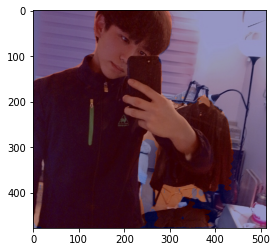

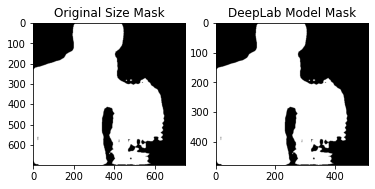

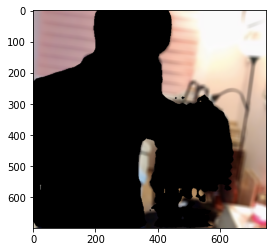

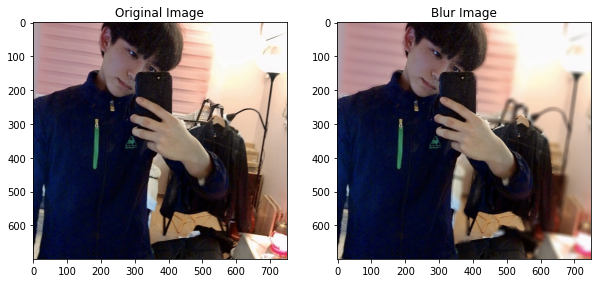

In [7]:
shallow_focus('정의경5.jpg','person','blur')

+ #### 헹거에 있는 옷들과 바닥에 있는 옷이 같이 인식이 되었다.

(960, 1280, 3) (384, 513, 3) 8


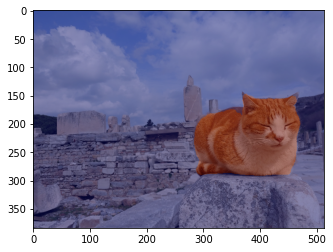

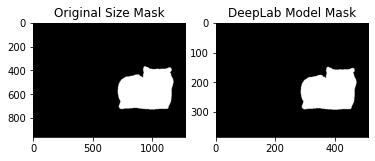

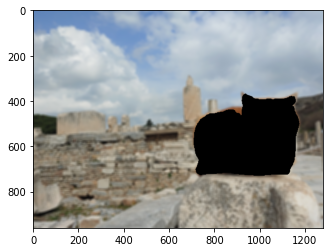

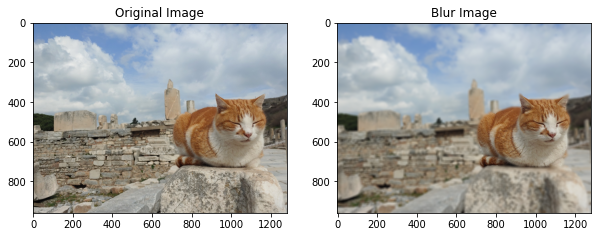

In [8]:
shallow_focus('CAT.jpg','cat','blur')

+ #### 고양이 귀가 뭉퉁하게 인식이 되었고 등 부분이 제대로 인식이 안되었다.

## Cromakey 결과물

(699, 750, 3) (478, 513, 3) 15


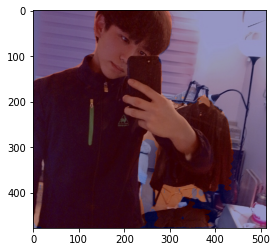

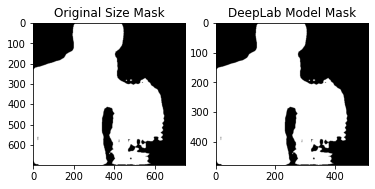

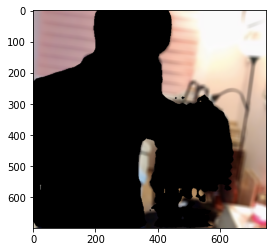

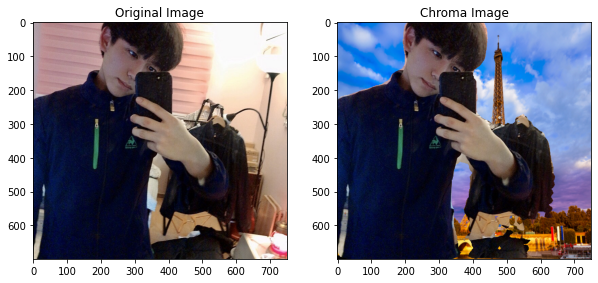

In [9]:
shallow_focus('정의경5.jpg','person','EiffelTower.jpg')

(960, 1280, 3) (384, 513, 3) 8


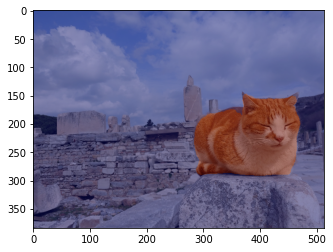

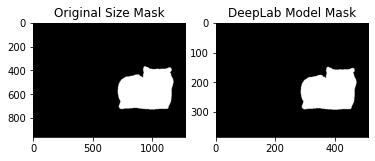

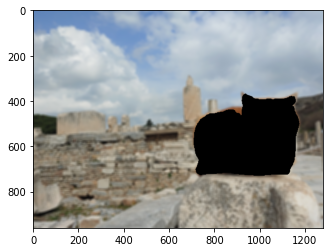

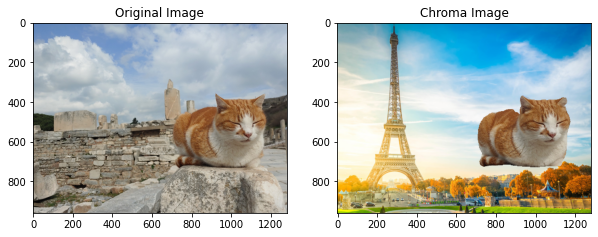

In [10]:
shallow_focus('CAT.jpg','cat','EiffelTower2.jpg')

---
# 회고

1. 아웃포커싱 효과를 적용해서 나의 인물모드 사진과 고양이사진, 배경전환 크로마키사진도 각각 1장씩 성공적으로 제작하였다.


2. 인물사진에서 입고 있는 옷이 어두운 색이다.   
헹거에 걸려있는 옷들과 바닥에 있는 옷의 색이 입고있는 옷과 비슷한계열인데 나의 팔이 헹거와 바닥에 있는 옷과 연결된 것처럼 인식을 하여서 배경과 분리가 제대로 안되었다.   

 고양이는 귀와 등부분이 제대로 인식이 안되었다.


3. 